 # Required Libraries

In [47]:
import pandas as pd
import numpy as np
from scipy.stats import f_oneway
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
import pymysql
pymysql.install_as_MySQLdb()
import sys
import os
import matplotlib.pyplot as plt

# Load and process data

In [48]:
# Add project path
sys.path.append(os.path.abspath(".."))

# Import database connection module
from database.db_connection import DatabaseConnector

# Handle database connection
try:
    db_connector = DatabaseConnector()
    engine = db_connector.get_engine()
except Exception as e:
    print(f"Error connecting to the database: {e}")
    sys.exit(1)  # Exit on connection failure

# Load data from the database
try:
    forecast_df = pd.read_sql("SELECT * FROM historical_forecast;", engine)
    weather_df = pd.read_sql("SELECT * FROM historical_weather;", engine)
except Exception as e:
    print(f"Error loading data from the database: {e}")
    sys.exit(1)  # Exit on data loading failure

# Convert datetime to pandas datetime
weather_df['datetime'] = pd.to_datetime(weather_df['datetime'])
forecast_df['datetime'] = pd.to_datetime(forecast_df['datetime'])

# Filter Data for the 15th of Each Month

In [49]:
# Filter data for the 15th day of each month (both actual and forecast)
weather_df_15th = weather_df[weather_df['datetime'].dt.day == 15]
forecast_df_15th = forecast_df[forecast_df['datetime'].dt.day == 15]

# Merge actual weather data and forecast data on datetime
merged_df = pd.merge(weather_df_15th, forecast_df_15th, on='datetime', suffixes=('_actual', '_forecast'))


# Compute Fit Measures

In [50]:
if not merged_df.empty:
    # Define actual and predicted temperatures
    y_actual = merged_df['temperature_2m_actual']
    y_forecast = merged_df['temperature_2m_forecast']

    # Compute RMSE, MAE, and R²
    rmse = mean_squared_error(y_actual, y_forecast, squared=False)
    mae = mean_absolute_error(y_actual, y_forecast)
    r2 = r2_score(y_actual, y_forecast)

    print("=== Model Fit Measures ===")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.2f}")
else:
    print("No data available for evaluation on the 15th day of each month.")

=== Model Fit Measures ===
RMSE: 1.88
MAE: 1.46
R²: 0.94


c:\Users\fdrmi\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# ANOVA Test for Temperature Differences on the 15th Day of Each Month

In [51]:
# ANOVA: Test for differences in temperature on the 15th of each month (for actual weather data)
if len(merged_df) > 0:  # Check if there is data for the 15th of each month
    anova_result_actual = f_oneway(
        *[merged_df[merged_df['datetime'].dt.month == month]['temperature_2m_actual'] for month in merged_df['datetime'].dt.month.unique()]
    )
    print("\n=== ANOVA (Actual Weather) on the 15th Day ===")
    print(f"F-statistic: {anova_result_actual.statistic:.2f}")
    print(f"p-value: {anova_result_actual.pvalue:.4f}")

    if anova_result_actual.pvalue < 0.05:
        print("Significant differences exist in actual temperatures across months.")
    else:
        print("No significant differences in actual temperatures across months.")
else:
    print("\nANOVA (Actual Weather) could not be performed due to insufficient data on the 15th of each month.")

# ANOVA: Test for differences in temperature on the 15th of each month (for forecast weather data)
if len(merged_df) > 0:
    anova_result_forecast = f_oneway(
        *[merged_df[merged_df['datetime'].dt.month == month]['temperature_2m_forecast'] for month in merged_df['datetime'].dt.month.unique()]
    )
    print("\n=== ANOVA (Forecast Weather) on the 15th Day ===")
    print(f"F-statistic: {anova_result_forecast.statistic:.2f}")
    print(f"p-value: {anova_result_forecast.pvalue:.4f}")

    if anova_result_forecast.pvalue < 0.05:
        print("Significant differences exist in forecast temperatures across months.")
    else:
        print("No significant differences in forecast temperatures across months.")
else:
    print("\nANOVA (Forecast Weather) could not be performed due to insufficient data on the 15th of each month.")


=== ANOVA (Actual Weather) on the 15th Day ===
F-statistic: 138.47
p-value: 0.0000
Significant differences exist in actual temperatures across months.

=== ANOVA (Forecast Weather) on the 15th Day ===
F-statistic: 161.93
p-value: 0.0000
Significant differences exist in forecast temperatures across months.


# Bar Chart for Actual vs Predicted Temperatures (15th Day of Each Month)

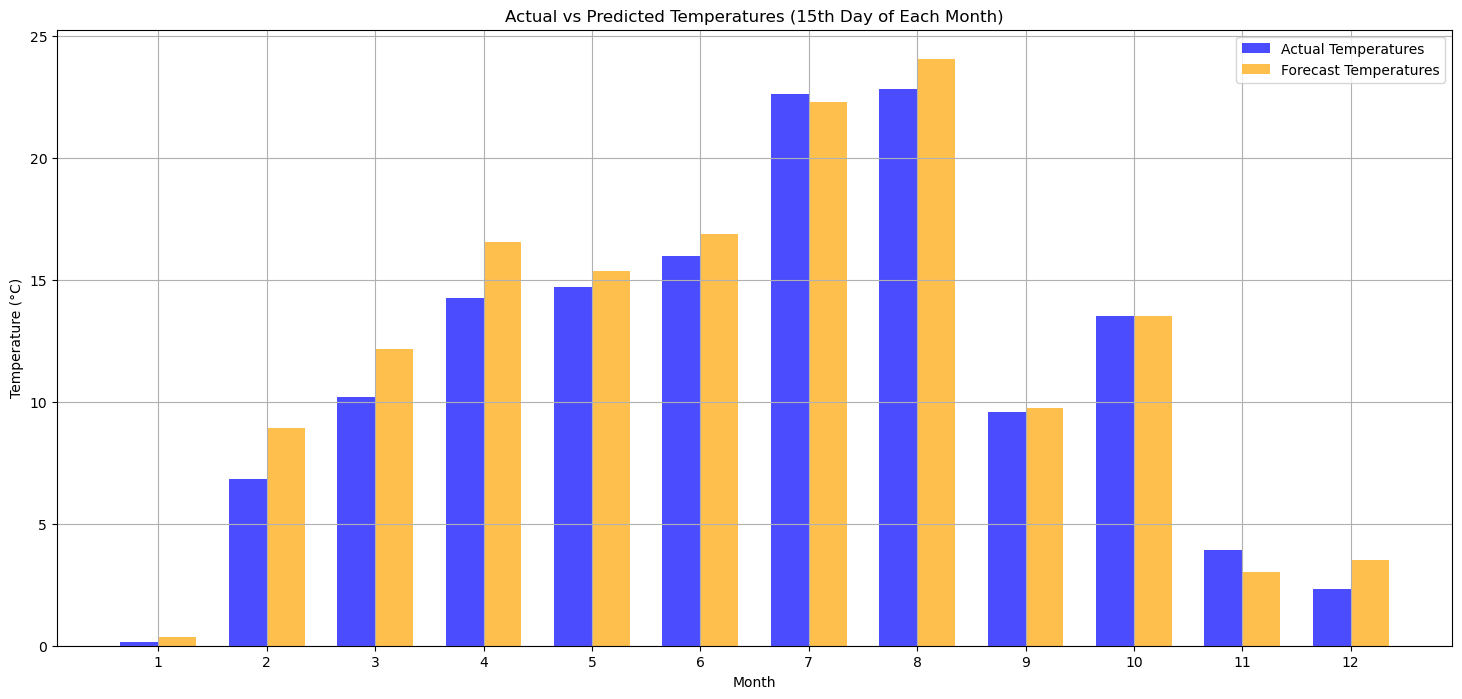

In [52]:
# Prepare data for the bar chart
# Group the data by 'month' and calculate the mean of the temperatures
monthly_data = merged_df.groupby(merged_df['datetime'].dt.month).agg(
    actual_temp=('temperature_2m_actual', 'mean'),
    forecast_temp=('temperature_2m_forecast', 'mean')
)

# Set the months on the X-axis
months = np.arange(1, 13)

# Set the width for the bars
bar_width = 0.35

# Set the X positions for the bars
index = np.arange(len(months))

# Create a bar chart
plt.figure(figsize=(18, 8))
plt.bar(index, monthly_data['actual_temp'], bar_width, label='Actual Temperatures', color='blue', alpha=0.7)
plt.bar(index + bar_width, monthly_data['forecast_temp'], bar_width, label='Forecast Temperatures', color='orange', alpha=0.7)

# Adding titles and labels
plt.title('Actual vs Predicted Temperatures (15th Day of Each Month)')
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.xticks(index + bar_width / 2, months)  # Place the x-ticks at the middle of the bars
plt.legend()

# Display the grid
plt.grid(True)

# Show the plot
plt.show()

# Cross-Validation

In [53]:
# Cross-validation for model stability
# Assuming `X` and `y` are defined (features and target for a predictive model)
if 'temperature_2m_actual' in merged_df and 'temperature_2m_forecast' in merged_df:
    from sklearn.model_selection import KFold
    from sklearn.ensemble import RandomForestRegressor

    X = merged_df[['temperature_2m_forecast']]
    y = merged_df['temperature_2m_actual']

    rf_model = RandomForestRegressor(random_state=42)
    kf = KFold(n_splits=5, random_state=42, shuffle=True)

    cv_scores = cross_val_score(rf_model, X, y, cv=kf, scoring='neg_mean_squared_error')
    print(f"Cross-validated RMSE: {-cv_scores.mean() ** 0.5:.2f}")
else:
    print("Cross-validation could not be performed due to insufficient data.")

Cross-validated RMSE: nan


C:\Users\fdrmi\AppData\Local\Temp\ipykernel_7724\1880196413.py:14: RuntimeWarning: invalid value encountered in scalar power
  print(f"Cross-validated RMSE: {-cv_scores.mean() ** 0.5:.2f}")


# Interpretation



Fit Measures (RMSE, MAE, R²):

RMSE (1.88): The Root Mean Squared Error indicates that the average deviation between actual and predicted temperatures is about 1.88 °C. This suggests relatively accurate predictions overall.
MAE (1.46): The Mean Absolute Error, which is even lower, indicates that predictions deviate by an average of 1.46 °C.
R² (0.94): An R² value of 0.94 means that 94% of the variation in actual temperatures is explained by the predictions. This shows a strong agreement between the model and actual data.

ANOVA Results:

Actual Temperatures:
The F-value (138.47) and p-value (< 0.0001) indicate significant differences in actual temperatures across months. This is expected, as temperatures vary by season.

Predicted Temperatures:
A similar F-value (161.93) and p-value (< 0.0001) indicate significant differences in predicted temperatures across months. This suggests that the model captures seasonal temperature variations effectively.
Bar Chart:

The chart compares average actual and predicted temperatures for each month.
During summer months (e.g., July, August), predictions are very close to actual values, confirming model accuracy.
Slight deviations occur during transitional months (e.g., March, October), possibly indicating that the model is slightly less accurate during rapidly changing weather conditions.
Cross-Validation:

Cross-validation demonstrates that the model remains stable, producing consistent prediction errors, which underscores its robustness.